# Train Test Split avec fenetre glissante

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_temporal_windows(X, y, window_size=100, stride=20, fault_start_times=None):
    """
    Crée des fenêtres temporelles avec labels appropriés

    X: (n_timesteps, n_simulations, n_features)
    y: (n_simulations,) - label de la simulation entière
    window_size: taille de la fenêtre temporelle
    stride: pas de déplacement
    fault_start_times: dict {sim_idx: timestamp_debut_panne} ou None pour runs sains

    Returns:
    X_windows: (n_windows, window_size, n_features)
    y_windows: (n_windows,) - label de chaque fenêtre
    metadata: infos sur chaque fenêtre (sim_idx, start_time, etc.)
    """
    X_windows = []
    y_windows = []
    metadata = []

    n_timesteps, n_simulations, n_features = X.shape

    for sim_idx in range(n_simulations):
        series = X[:, sim_idx, :]  # (n_timesteps, n_features)
        sim_label = y[sim_idx]

        # Déterminer où commence la panne (si elle existe)
        if fault_start_times and sim_idx in fault_start_times:
            fault_start = fault_start_times[sim_idx]
        else:
            fault_start = None  # Run sain, pas de panne

        # Créer des fenêtres glissantes
        for start in range(0, n_timesteps - window_size + 1, stride):
            end = start + window_size
            window = series[start:end, :]

            # Déterminer le label de cette fenêtre
            if fault_start is None:
                # Run sain → toutes les fenêtres sont normales
                window_label = 0
            else:
                # Run avec panne → déterminer si la fenêtre est avant ou après la panne
                window_center = (start + end) // 2

                if window_center < fault_start:
                    # Fenêtre avant la panne → normal
                    window_label = 0
                else:
                    # Fenêtre pendant/après la panne → type de panne
                    window_label = sim_label

            X_windows.append(window)
            y_windows.append(window_label)
            metadata.append({
                'sim_idx': sim_idx,
                'start_time': start,
                'end_time': end,
                'original_label': sim_label
            })

    return np.array(X_windows), np.array(y_windows), metadata


# Exemple d'utilisation avec vos données
# ========================================

# Vos données d'entraînement
X_train = np.random.randn(50, 200, 52)  # 500 timesteps, 1000 sims, 52 features

# Labels : 500 sains + 500 avec pannes (25 de chaque type)
y_train = np.concatenate([
    np.zeros(500, dtype=int),
    np.repeat(np.arange(1, 21), 25)
])

# Définir quand les pannes commencent dans les runs avec pannes
fault_start_times_train = {}
for sim_idx in range(500, 1000):  # Simulations avec pannes
    # Dans le train, pannes à ~1h (par exemple timestep 60 sur 500)
    fault_start_times_train[sim_idx] = np.random.randint(50, 100)

# Créer les fenêtres d'entraînement
window_size = 100  # 100 timesteps par fenêtre
stride = 20        # Déplacement de 20 timesteps

X_train_windows, y_train_windows, train_metadata = create_temporal_windows(
    X_train,
    y_train,
    window_size=window_size,
    stride=stride,
    fault_start_times=fault_start_times_train
)

print(f"Fenêtres d'entraînement : {X_train_windows.shape}")
print(f"Distribution des labels : {np.bincount(y_train_windows)}")
# Vous devriez voir beaucoup de label 0 (fenêtres normales) + fenêtres de chaque panne

# Vérifier l'équilibre
unique, counts = np.unique(y_train_windows, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} fenêtres")

Fenêtres d'entraînement : (21000, 100, 52)
Distribution des labels : [11361   478   475   485   481   478   482   477   480   492   483   489
   486   484   482   478   478   484   481   485   481]
Label 0: 11361 fenêtres
Label 1: 478 fenêtres
Label 2: 475 fenêtres
Label 3: 485 fenêtres
Label 4: 481 fenêtres
Label 5: 478 fenêtres
Label 6: 482 fenêtres
Label 7: 477 fenêtres
Label 8: 480 fenêtres
Label 9: 492 fenêtres
Label 10: 483 fenêtres
Label 11: 489 fenêtres
Label 12: 486 fenêtres
Label 13: 484 fenêtres
Label 14: 482 fenêtres
Label 15: 478 fenêtres
Label 16: 478 fenêtres
Label 17: 484 fenêtres
Label 18: 481 fenêtres
Label 19: 485 fenêtres
Label 20: 481 fenêtres


## Application sur les données de test


In [ ]:
# Vos données de test avec pannes à 8h
X_test = np.random.randn(960, 100, 52)  # 960 timesteps (8h à ~120 timesteps/h)
y_test = np.repeat(np.arange(1, 21), 5)  # 5 simulations par type de panne

# Dans le test, pannes à ~8h (timestep 480 par exemple)
fault_start_times_test = {}
for sim_idx in range(100):
    fault_start_times_test[sim_idx] = 480  # Panne à 8h

# Créer des fenêtres de test AVEC CHEVAUCHEMENT pour classification continue
X_test_windows, y_test_windows, test_metadata = create_temporal_windows(
    X_test,
    y_test,
    window_size=window_size,
    stride=10,  # Plus petit stride pour détection plus fine
    fault_start_times=fault_start_times_test
)

print(f"Fenêtres de test : {X_test_windows.shape}")


Fenêtres de test : (8700, 100, 52)


: 

## Appliquer GASF et entraîner le modèle


In [ ]:
!pip install pyts
from pyts.image import GramianAngularField

def apply_gasf_to_windows(X_windows):
    """
    Applique GASF à chaque fenêtre
    X_windows: (n_windows, window_size, n_features)
    """
    gasf = GramianAngularField(method='summation')
    n_windows, window_size, n_features = X_windows.shape

    # GASF produit une image (window_size, window_size) par feature
    X_gasf = np.zeros((n_windows, window_size, window_size, n_features))

    for win_idx in range(n_windows):
        for feat_idx in range(n_features):
            series = X_windows[win_idx, :, feat_idx].reshape(1, -1)
            X_gasf[win_idx, :, :, feat_idx] = gasf.fit_transform(series)[0]

        if (win_idx + 1) % 1000 == 0:
            print(f"GASF appliqué à {win_idx + 1}/{n_windows} fenêtres")

    return X_gasf

# Appliquer GASF
print("Application GASF sur train...")
X_train_gasf = apply_gasf_to_windows(X_train_windows)

print("Application GASF sur test...")
X_test_gasf = apply_gasf_to_windows(X_test_windows)

print(f"Train GASF shape: {X_train_gasf.shape}")
print(f"Test GASF shape: {X_test_gasf.shape}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.5 MB/s eta 0:00:00a 0:00:01
Application GASF sur train...
GASF appliqué à 1000/21000 fenêtres
GASF appliqué à 2000/21000 fenêtres


: 

: 

## Modèle CNN pour classifier les fenêtres


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_cnn_classifier(input_shape, num_classes=21):
    """
    CNN pour classifier les images GASF
    input_shape: (window_size, window_size, n_features)
    num_classes: 21 (0=normal, 1-20=types de pannes)
    """
    inputs = keras.Input(shape=input_shape)

    # Traiter chaque feature séparément puis combiner
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)  # Pour gérer différentes tailles

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Construire et compiler le modèle
model = build_cnn_classifier(
    input_shape=(window_size, window_size, X_train_gasf.shape[-1]),
    num_classes=21
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

## Entraînement avec gestion du déséquilibre

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculer les poids de classe pour gérer le déséquilibre
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_windows),
    y=y_train_windows
)
class_weight_dict = dict(enumerate(class_weights))

print("Poids de classe:", class_weight_dict)

# Split train/validation
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_gasf, y_train_windows,
    test_size=0.2,
    stratify=y_train_windows,
    random_state=42
)

# Entraînement
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

## Prédiction et visualisation temporelle

In [ ]:
import matplotlib.pyplot as plt

def predict_temporal_evolution(model, X_test_gasf, test_metadata, simulation_idx=0):
    """
    Prédit l'évolution temporelle pour une simulation de test
    """
    # Filtrer les fenêtres de cette simulation
    sim_windows = [i for i, meta in enumerate(test_metadata)
                   if meta['sim_idx'] == simulation_idx]

    X_sim = X_test_gasf[sim_windows]
    predictions = model.predict(X_sim)
    predicted_classes = np.argmax(predictions, axis=1)

    # Extraire les temps
    times = [test_metadata[i]['start_time'] for i in sim_windows]

    # Visualiser
    plt.figure(figsize=(15, 5))
    plt.plot(times, predicted_classes, marker='o', linewidth=2)
    plt.axhline(y=0, color='green', linestyle='--', label='Normal')
    plt.axvline(x=480, color='red', linestyle='--', label='Début panne réel (8h)')
    plt.xlabel('Temps (timesteps)')
    plt.ylabel('Classe prédite')
    plt.title(f'Évolution temporelle - Simulation {simulation_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return times, predicted_classes

# Tester sur plusieurs simulations
for sim_idx in range(5):
    times, preds = predict_temporal_evolution(model, X_test_gasf, test_metadata, sim_idx)

    # Vérifier quand le modèle détecte la panne
    fault_detected_at = None
    for t, pred in zip(times, preds):
        if pred != 0:  # Première détection d'anomalie
            fault_detected_at = t
            break

    true_label = y_test[sim_idx]
    print(f"Simulation {sim_idx} (vraie panne: {true_label}):")
    print(f"  - Panne détectée au timestep: {fault_detected_at}")
    print(f"  - Délai de détection: {fault_detected_at - 480 if fault_detected_at else 'Non détectée'}")

Génération des données d'entraînement...
X_train shape: (200, 200, 10)
y_train shape: (200,)
Distribution labels train: [100   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5]

Génération des données de test...
X_test shape: (400, 40, 10)
y_test shape: (40,)

Création des fenêtres d'entraînement...
Fenêtres train: (2200, 50, 10)
Labels train: (2200,)
Distribution: [1280   47   45   44   46   45   44   44   46   47   49   46   44   48
   48   45   46   47   49   45   45]

Création des fenêtres de test...
Fenêtres test: (2840, 50, 10)

APPLICATION GASF (peut prendre quelques minutes...)

GASF sur train...
Batch 1/22 terminé (100/2200 fenêtres)
Batch 2/22 terminé (200/2200 fenêtres)
Batch 3/22 terminé (300/2200 fenêtres)
Batch 4/22 terminé (400/2200 fenêtres)
Batch 5/22 terminé (500/2200 fenêtres)
Batch 6/22 terminé (600/2200 fenêtres)
Batch 7/22 terminé (700/2200 fenêtres)
Batch 8/22 terminé (800/2200 fenêtres)
Batch 9/22 terminé (900/2200 fenêtres)
Batch 1

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,565 (33.46 KB)

 Trainable params: 8,565 (33.46 KB)

 Non-trainable params: 0 (0.00 B)


ENTRAÎNEMENT
Train: (1760, 50, 50, 3), Val: (440, 50, 50, 3)
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0473 - loss: 3.0568 - val_accuracy: 0.0159 - val_loss: 3.0427
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0304 - loss: 3.1041 - val_accuracy: 0.0205 - val_loss: 3.0449
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0229 - loss: 3.0724 - val_accuracy: 0.0250 - val_loss: 3.0450
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0726 - loss: 2.9486 - val_accuracy: 0.2500 - val_loss: 3.0317
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0811 - loss: 3.0248 - val_accuracy: 0.0205 - val_loss: 3.0501
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0194 - loss: 3.0778 - val_accuracy: 0.0182 - val_loss: 3.0491
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0255 - loss: 3.1239 - val_accuracy: 0.0227 - val_loss: 3.0502
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

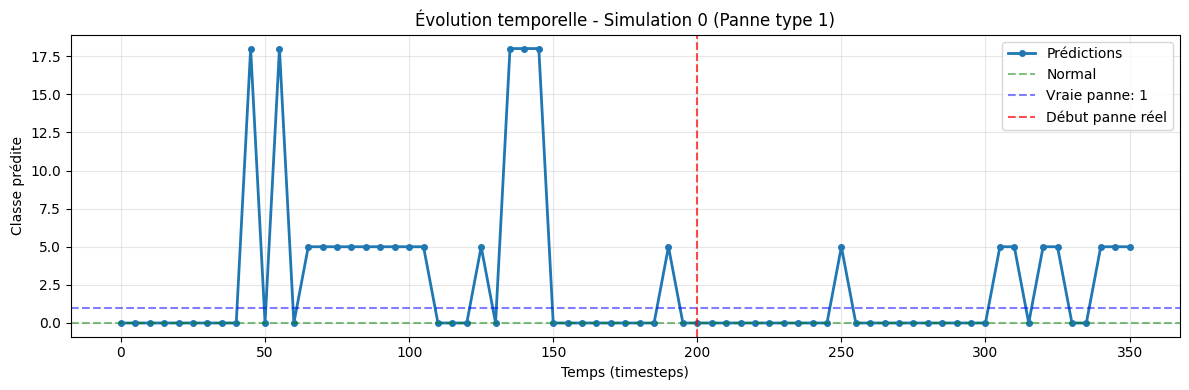


Simulation 0:
  Vraie panne: Type 1
  Début réel: timestep 200
  Détectée à: timestep 45
  Délai: -155 timesteps
  Classe la plus prédite: 5 (8 fois)


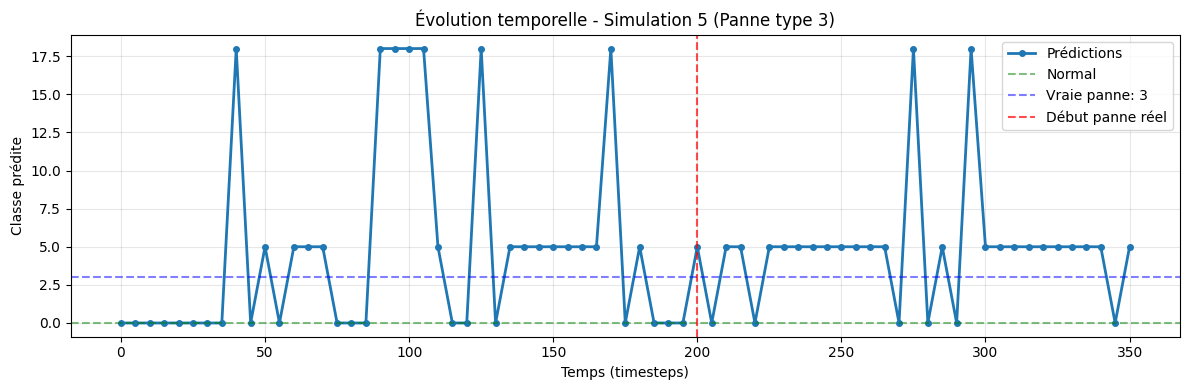


Simulation 5:
  Vraie panne: Type 3
  Début réel: timestep 200
  Détectée à: timestep 40
  Délai: -160 timesteps
  Classe la plus prédite: 5 (23 fois)


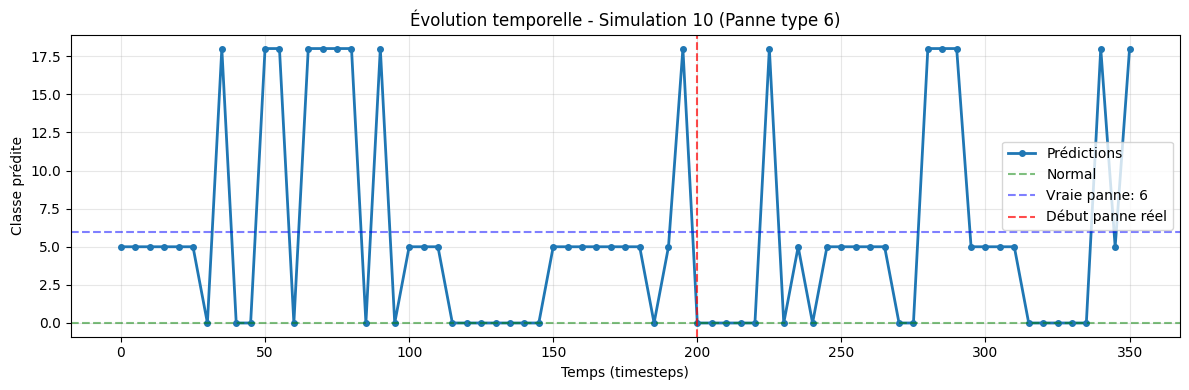


Simulation 10:
  Vraie panne: Type 6
  Début réel: timestep 200
  Détectée à: timestep Non détectée


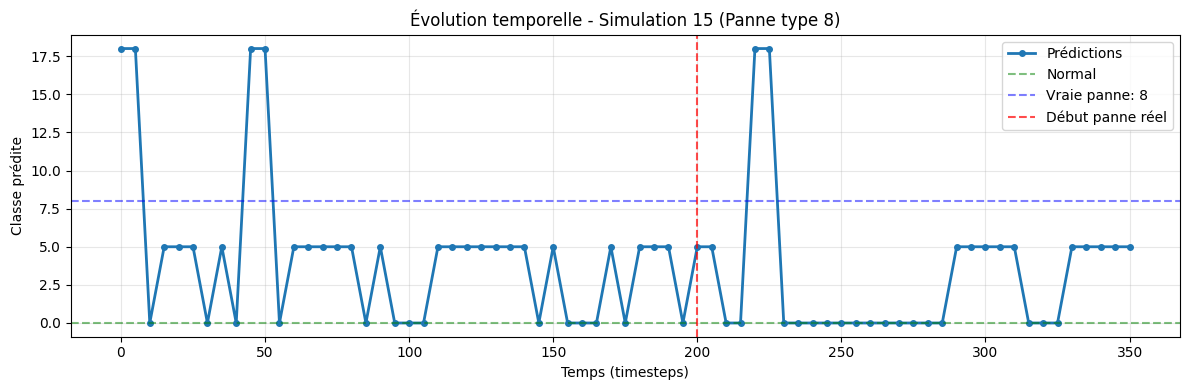


Simulation 15:
  Vraie panne: Type 8
  Début réel: timestep 200
  Détectée à: timestep Non détectée

MATRICE DE CONFUSION


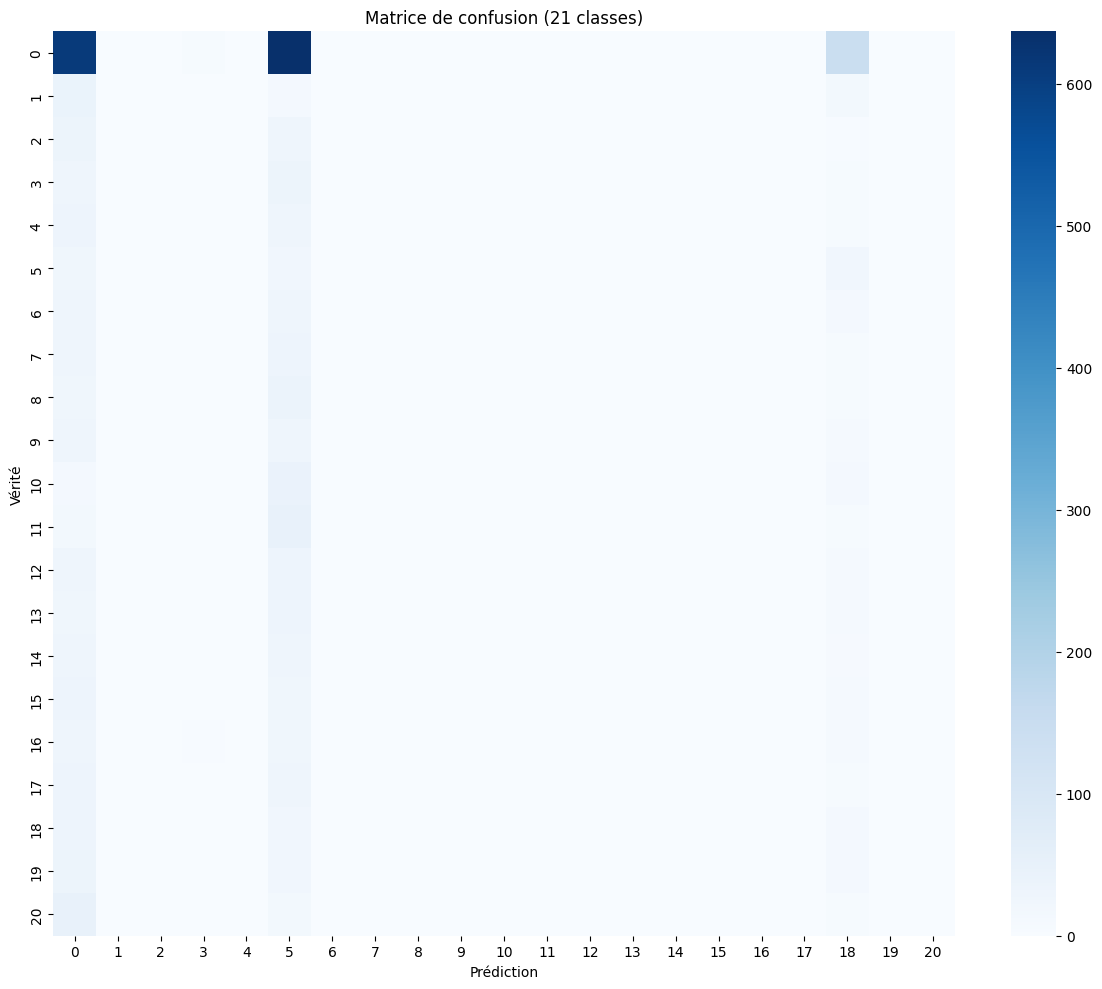


Rapport de classification:
              precision    recall  f1-score   support

    Classe 0       0.50      0.44      0.46      1400
    Classe 1       0.00      0.00      0.00        72
    Classe 2       0.00      0.00      0.00        72
    Classe 3       0.00      0.00      0.00        72
    Classe 4       0.00      0.00      0.00        72
    Classe 5       0.02      0.33      0.04        72
    Classe 6       0.00      0.00      0.00        72
    Classe 7       0.00      0.00      0.00        72
    Classe 8       0.00      0.00      0.00        72
    Classe 9       0.00      0.00      0.00        72
   Classe 10       0.00      0.00      0.00        72
   Classe 11       0.00      0.00      0.00        72
   Classe 12       0.00      0.00      0.00        72
   Classe 13       0.00      0.00      0.00        72
   Classe 14       0.00      0.00      0.00        72
   Classe 15       0.00      0.00      0.00        72
   Classe 16       0.00      0.00      0.00        72

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ====================================
# 1. GÉNÉRATION DE DONNÉES SIMPLIFIÉES
# ====================================

np.random.seed(42)

# Dimensions réduites
n_timesteps_train = 200  # Au lieu de 500
n_timesteps_test = 400   # Au lieu de 960
n_simulations = 200      # Au lieu de 1000 (100 saines + 100 avec pannes)
n_features = 10          # Au lieu de 52

print("Génération des données d'entraînement...")

# Données d'entraînement
X_train = np.random.randn(n_timesteps_train, n_simulations, n_features)

# Labels : 100 saines (0) + 100 avec pannes (5 de chaque type 1-20)
y_train = np.concatenate([
    np.zeros(100, dtype=int),
    np.repeat(np.arange(1, 21), 5)
])

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Distribution labels train: {np.bincount(y_train)}")

# Pannes commencent à ~timestep 40 (environ 20% du temps) dans le train
fault_start_times_train = {}
for sim_idx in range(100, 200):
    fault_start_times_train[sim_idx] = np.random.randint(30, 60)

# Données de test
print("\nGénération des données de test...")
X_test = np.random.randn(n_timesteps_test, 40, n_features)  # 40 simulations test (2 par type)
y_test = np.repeat(np.arange(1, 21), 2)

# Pannes commencent à ~timestep 200 (environ 50% du temps) dans le test
fault_start_times_test = {}
for sim_idx in range(40):
    fault_start_times_test[sim_idx] = 200

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


# ====================================
# 2. CRÉATION DES FENÊTRES TEMPORELLES
# ====================================

def create_temporal_windows(X, y, window_size=50, stride=10, fault_start_times=None):
    """
    Crée des fenêtres temporelles avec labels appropriés
    """
    X_windows = []
    y_windows = []
    metadata = []

    n_timesteps, n_simulations, n_features = X.shape

    for sim_idx in range(n_simulations):
        series = X[:, sim_idx, :]
        sim_label = y[sim_idx]

        if fault_start_times and sim_idx in fault_start_times:
            fault_start = fault_start_times[sim_idx]
        else:
            fault_start = None

        for start in range(0, n_timesteps - window_size + 1, stride):
            end = start + window_size
            window = series[start:end, :]

            if fault_start is None:
                window_label = 0
            else:
                window_center = (start + end) // 2
                if window_center < fault_start:
                    window_label = 0
                else:
                    window_label = sim_label

            X_windows.append(window)
            y_windows.append(window_label)
            metadata.append({
                'sim_idx': sim_idx,
                'start_time': start,
                'end_time': end,
                'original_label': sim_label
            })

    return np.array(X_windows), np.array(y_windows), metadata


window_size = 50  # Fenêtre de 50 timesteps
stride_train = 15  # Stride plus grand pour réduire le nombre de fenêtres
stride_test = 5    # Stride plus petit pour le test (détection fine)

print("\nCréation des fenêtres d'entraînement...")
X_train_windows, y_train_windows, train_metadata = create_temporal_windows(
    X_train,
    y_train,
    window_size=window_size,
    stride=stride_train,
    fault_start_times=fault_start_times_train
)

print(f"Fenêtres train: {X_train_windows.shape}")
print(f"Labels train: {y_train_windows.shape}")
print(f"Distribution: {np.bincount(y_train_windows)}")

print("\nCréation des fenêtres de test...")
X_test_windows, y_test_windows, test_metadata = create_temporal_windows(
    X_test,
    y_test,
    window_size=window_size,
    stride=stride_test,
    fault_start_times=fault_start_times_test
)

print(f"Fenêtres test: {X_test_windows.shape}")


# ====================================
# 3. APPLICATION GASF SIMPLIFIÉE
# ====================================

print("\n" + "="*50)
print("APPLICATION GASF (peut prendre quelques minutes...)")
print("="*50)

from pyts.image import GramianAngularField

def apply_gasf_batch(X_windows, batch_size=100, n_features_gasf=3):
    """
    Applique GASF par batch et sur un sous-ensemble de features pour économiser la mémoire
    """
    gasf = GramianAngularField(method='summation')
    n_windows, window_size, n_features = X_windows.shape

    # Ne garder que les premières features pour GASF
    n_features_gasf = min(n_features_gasf, n_features)
    X_gasf = np.zeros((n_windows, window_size, window_size, n_features_gasf))

    n_batches = (n_windows + batch_size - 1) // batch_size

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_windows)

        for feat_idx in range(n_features_gasf):
            for win_idx in range(start_idx, end_idx):
                series = X_windows[win_idx, :, feat_idx].reshape(1, -1)
                X_gasf[win_idx, :, :, feat_idx] = gasf.fit_transform(series)[0]

        print(f"Batch {batch_idx + 1}/{n_batches} terminé ({end_idx}/{n_windows} fenêtres)")

    return X_gasf

# Appliquer GASF sur seulement 3 features pour économiser la mémoire
print("\nGASF sur train...")
X_train_gasf = apply_gasf_batch(X_train_windows, batch_size=100, n_features_gasf=3)

print("\nGASF sur test...")
X_test_gasf = apply_gasf_batch(X_test_windows, batch_size=100, n_features_gasf=3)

print(f"\nTrain GASF final: {X_train_gasf.shape}")
print(f"Test GASF final: {X_test_gasf.shape}")


# ====================================
# 4. MODÈLE CNN SIMPLIFIÉ
# ====================================

def build_simple_cnn(input_shape, num_classes=21):
    """
    CNN plus léger
    """
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

print("\n" + "="*50)
print("CONSTRUCTION DU MODÈLE")
print("="*50)

model = build_simple_cnn(
    input_shape=(window_size, window_size, X_train_gasf.shape[-1]),
    num_classes=21
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


# ====================================
# 5. ENTRAÎNEMENT
# ====================================

print("\n" + "="*50)
print("ENTRAÎNEMENT")
print("="*50)

# Poids de classe
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_windows),
    y=y_train_windows
)
class_weight_dict = dict(enumerate(class_weights))

# Split train/val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_gasf, y_train_windows,
    test_size=0.2,
    stratify=y_train_windows,
    random_state=42
)

print(f"Train: {X_tr.shape}, Val: {X_val.shape}")

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=20,  # Moins d'epochs
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ],
    verbose=1
)


# ====================================
# 6. ÉVALUATION ET VISUALISATION
# ====================================

print("\n" + "="*50)
print("ÉVALUATION")
print("="*50)

# Évaluation globale
test_loss, test_acc = model.evaluate(X_test_gasf, y_test_windows, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

# Prédiction temporelle pour quelques simulations
predictions = model.predict(X_test_gasf, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

def visualize_temporal_predictions(sim_idx):
    """
    Visualise les prédictions temporelles pour une simulation
    """
    sim_windows = [i for i, meta in enumerate(test_metadata)
                   if meta['sim_idx'] == sim_idx]

    times = [test_metadata[i]['start_time'] for i in sim_windows]
    preds = predicted_classes[sim_windows]
    true_label = y_test[sim_idx]

    plt.figure(figsize=(12, 4))
    plt.plot(times, preds, marker='o', linewidth=2, markersize=4, label='Prédictions')
    plt.axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Normal')
    plt.axhline(y=true_label, color='blue', linestyle='--', alpha=0.5, label=f'Vraie panne: {true_label}')
    plt.axvline(x=200, color='red', linestyle='--', alpha=0.7, label='Début panne réel')
    plt.xlabel('Temps (timesteps)')
    plt.ylabel('Classe prédite')
    plt.title(f'Évolution temporelle - Simulation {sim_idx} (Panne type {true_label})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Statistiques de détection
    fault_detected_at = None
    for t, pred in zip(times, preds):
        if pred != 0:
            fault_detected_at = t
            break

    print(f"\nSimulation {sim_idx}:")
    print(f"  Vraie panne: Type {true_label}")
    print(f"  Début réel: timestep 200")
    print(f"  Détectée à: timestep {fault_detected_at if fault_detected_at else 'Non détectée'}")
    if fault_detected_at:
        print(f"  Délai: {fault_detected_at - 200} timesteps")
        # Classe la plus prédite après détection
        preds_after_fault = [p for t, p in zip(times, preds) if t >= 200 and p != 0]
        if preds_after_fault:
            from collections import Counter
            most_common = Counter(preds_after_fault).most_common(1)[0]
            print(f"  Classe la plus prédite: {most_common[0]} ({most_common[1]} fois)")

# Visualiser 4 exemples
print("\n" + "="*50)
print("VISUALISATIONS")
print("="*50)

for sim_idx in [0, 5, 10, 15]:
    visualize_temporal_predictions(sim_idx)

# Matrice de confusion globale
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("\n" + "="*50)
print("MATRICE DE CONFUSION")
print("="*50)

cm = confusion_matrix(y_test_windows, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion (21 classes)')
plt.tight_layout()
plt.show()

# Rapport de classification
print("\nRapport de classification:")
print(classification_report(y_test_windows, predicted_classes,
                          target_names=[f'Classe {i}' for i in range(21)],
                          zero_division=0))

print("\n" + "="*50)
print("SCRIPT TERMINÉ")
print("="*50)

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 791.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 90.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [3]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from load_df import get_2h_df_from_csv

# ====================================
# 1. CHARGEMENT DES DONNÉES
# ====================================

print("Chargement des données...")

fault_free_test, fault_free_train, faulty_test, faulty_train = get_2h_df_from_csv()



# TRAIN
X_fault_free_train = fault_free_train.drop(columns="faultNumber")
X_faulty_train = faulty_train.drop(columns="faultNumber")

# TEST
X_fault_free_test = fault_free_test.drop(columns="faultNumber")
X_faulty_test = faulty_test.drop(columns="faultNumber")

y_fault_free_train = fault_free_train['faultNumber']
y_fault_free_test = fault_free_test['faultNumber']

y_faulty_train = faulty_train['faultNumber']
y_faulty_test = faulty_test['faultNumber']

print(f"Fault-free train: {X_fault_free_train.shape}")
print(f"Faulty train: {X_faulty_train.shape}")
print(f"Fault-free test: {X_fault_free_test.shape}")
print(f"Faulty test: {X_faulty_test.shape}")

# ====================================
# 2. CRÉATION DES LABELS
# ====================================

# Labels pour données saines


print(f"y_fault_free_train: {y_fault_free_train.shape}")
print(f"y_faulty_train: {y_faulty_train.shape}")

# ====================================
# 3. COMBINAISON ET MÉLANGE
# ====================================

# Combiner train
X_train = np.concatenate([X_fault_free_train, X_faulty_train], axis=1)
y_train = np.concatenate([y_fault_free_train, y_faulty_train])

# Combiner test
X_test = np.concatenate([X_fault_free_test, X_faulty_test], axis=1)
y_test = np.concatenate([y_fault_free_test, y_faulty_test])

print(f"\nAprès combinaison:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Mélanger (important pour l'entraînement)
X_train, y_train = shuffle(X_train.T, y_train, random_state=42)
X_train = X_train.T

X_test, y_test = shuffle(X_test.T, y_test, random_state=42)
X_test = X_test.T

print(f"\nDistribution train: {np.bincount(y_train)}")
print(f"Distribution test: {np.bincount(y_test)}")

# ====================================
# 4. PREPROCESSING
# ====================================

# Transposer: (timesteps, simulations, features) → (simulations, timesteps, features)
X_train = np.transpose(X_train, (1, 0, 2))
X_test = np.transpose(X_test, (1, 0, 2))

print(f"\nAprès transpose:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

# Normalisation
n_train, n_time, n_feat = X_train.shape
X_train_flat = X_train.reshape(-1, n_feat)

scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_train = X_train_flat.reshape(n_train, n_time, n_feat)

n_test = X_test.shape[0]
X_test_flat = X_test.reshape(-1, n_feat)
X_test_flat = scaler.transform(X_test_flat)
X_test = X_test_flat.reshape(n_test, X_test.shape[1], n_feat)

print("Normalisation terminée")

# ====================================
# 5. SPLIT TRAIN/VALIDATION
# ====================================

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print(f"\nSplit final:")
print(f"Train: {X_tr.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

# ====================================
# 6. MODÈLE BASELINE
# ====================================

def build_lstm_baseline(input_shape, num_classes=21):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(32),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_lstm_baseline(
    input_shape=(X_tr.shape[1], X_tr.shape[2]),
    num_classes=21
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ====================================
# 7. ENTRAÎNEMENT
# ====================================

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ],
    verbose=1
)

# ====================================
# 8. ÉVALUATION
# ====================================

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print("\n" + classification_report(y_test, y_pred_classes))

2025-12-03 14:04:09.191185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Chargement des données...
Fault-free train: (19500, 54)
Faulty train: (390000, 54)
Fault-free test: (20000, 54)
Faulty test: (400000, 54)
y_fault_free_train: (19500,)
y_faulty_train: (390000,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 19500 and the array at index 1 has size 390000

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# ====================================
# 1. CHARGEMENT DES DONNÉES
# ====================================

print("Chargement des données...")


print(f"Fault-free train: {fault_free_train.shape}")
print(f"Faulty train: {faulty_train.shape}")
print(f"Fault-free test: {fault_free_test.shape}")
print(f"Faulty test: {faulty_test.shape}")

print("\nColonnes:", fault_free_train.columns.tolist()[:5], "...")

# ====================================
# 2. FONCTION POUR CONVERTIR EN 3D
# ====================================

def dataframe_to_3d(df, has_fault=True):
    """
    Convertit un DataFrame (format long) en array 3D

    Format d'entrée: (n_rows, n_cols) où chaque simulation a plusieurs lignes (timesteps)
    Format de sortie: (n_simulations, n_timesteps, n_features)
    """
    # Identifier les colonnes à supprimer
    cols_to_drop = ['faultNumber', 'simulationRun', 'sample']
    feature_cols = [col for col in df.columns if col not in cols_to_drop]

    # Extraire les features
    X_df = df[feature_cols]

    # Grouper par simulation
    simulations = []
    simulation_ids = sorted(df['simulationRun'].unique())

    print(f"  Nombre de simulations uniques: {len(simulation_ids)}")

    for sim_id in simulation_ids:
        sim_data = df[df['simulationRun'] == sim_id][feature_cols]
        simulations.append(sim_data.values)

    X_3d = np.array(simulations)

    # Extraire les labels (un par simulation)
    if has_fault:
        y = df.groupby('simulationRun')['faultNumber'].first().values
    else:
        y = np.zeros(len(simulation_ids), dtype=int)

    return X_3d, y

# ====================================
# 3. CONVERSION EN 3D
# ====================================

print("\nConversion en 3D...")
print("Fault-free train...")
X_fault_free_train, y_fault_free_train = dataframe_to_3d(fault_free_train, has_fault=False)

print("Faulty train...")
X_faulty_train, y_faulty_train = dataframe_to_3d(faulty_train, has_fault=True)

print("Fault-free test...")
X_fault_free_test, y_fault_free_test = dataframe_to_3d(fault_free_test, has_fault=False)

print("Faulty test...")
X_faulty_test, y_faulty_test = dataframe_to_3d(faulty_test, has_fault=True)

print(f"\n{'='*60}")
print("SHAPES APRÈS CONVERSION 3D")
print(f"{'='*60}")
print(f"X_fault_free_train: {X_fault_free_train.shape}")
print(f"X_faulty_train: {X_faulty_train.shape}")
print(f"X_fault_free_test: {X_fault_free_test.shape}")
print(f"X_faulty_test: {X_faulty_test.shape}")

print(f"\ny_fault_free_train: {y_fault_free_train.shape}")
print(f"y_faulty_train: {y_faulty_train.shape}")
print(f"y_fault_free_test: {y_fault_free_test.shape}")
print(f"y_faulty_test: {y_faulty_test.shape}")

print(f"\nDistribution faulty_train: {np.bincount(y_faulty_train)}")

# ====================================
# 4. COMBINAISON
# ====================================

print(f"\n{'='*60}")
print("COMBINAISON DES DONNÉES")
print(f"{'='*60}")

# Combiner TRAIN
X_train_full = np.concatenate([X_fault_free_train, X_faulty_train], axis=0)
y_train_full = np.concatenate([y_fault_free_train, y_faulty_train])

# Combiner TEST (à ne pas toucher jusqu'à la fin)
X_test_final = np.concatenate([X_fault_free_test, X_faulty_test], axis=0)
y_test_final = np.concatenate([y_fault_free_test, y_faulty_test])

print(f"X_train_full: {X_train_full.shape}")
print(f"y_train_full: {y_train_full.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_test_final: {y_test_final.shape}")

# Mélanger le train
X_train_full, y_train_full = shuffle(X_train_full, y_train_full, random_state=42)
X_test_final, y_test_final = shuffle(X_test_final, y_test_final, random_state=42)

print(f"\nDistribution train: {np.bincount(y_train_full)}")
print(f"Distribution test: {np.bincount(y_test_final)}")

# ====================================
# 5. TRAIN/VAL SPLIT
# ====================================

print(f"\n{'='*60}")
print("TRAIN/VAL SPLIT")
print(f"{'='*60}")

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

print(f"Train:      {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test_final.shape}")

print(f"\nDistribution Train: {np.bincount(y_train)}")
print(f"Distribution Val:   {np.bincount(y_val)}")
print(f"Distribution Test:  {np.bincount(y_test_final)}")

# ====================================
# 6. NORMALISATION (sans leakage)
# ====================================

print(f"\n{'='*60}")
print("NORMALISATION")
print(f"{'='*60}")

n_train, n_time, n_feat = X_train.shape

# Reshape pour normalisation
X_train_flat = X_train.reshape(-1, n_feat)
X_val_flat = X_val.reshape(-1, n_feat)
X_test_flat = X_test_final.reshape(-1, n_feat)

# Fit sur train uniquement
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flat)
X_val_normalized = scaler.transform(X_val_flat)
X_test_normalized = scaler.transform(X_test_flat)

# Reshape back
X_train = X_train_normalized.reshape(n_train, n_time, n_feat)
X_val = X_val_normalized.reshape(X_val.shape[0], n_time, n_feat)
X_test_final = X_test_normalized.reshape(X_test_final.shape[0], X_test_final.shape[1], n_feat)

print("Normalisation terminée (sans data leakage)")
print(f"X_train normalisé: mean={X_train.mean():.4f}, std={X_train.std():.4f}")
print(f"X_val normalisé: mean={X_val.mean():.4f}, std={X_val.std():.4f}")

# ====================================
# 7. MODÈLE BASELINE
# ====================================

print(f"\n{'='*60}")
print("CONSTRUCTION DU MODÈLE")
print(f"{'='*60}")

from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_baseline(input_shape, num_classes=21):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),

        layers.LSTM(64),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_lstm_baseline(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=21
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ====================================
# 8. ENTRAÎNEMENT
# ====================================

print(f"\n{'='*60}")
print("ENTRAÎNEMENT")
print(f"{'='*60}")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1
        )
    ],
    verbose=1
)

# ====================================
# 9. ÉVALUATION FINALE
# ====================================

print(f"\n{'='*60}")
print("ÉVALUATION FINALE")
print(f"{'='*60}")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Val accuracy:   {val_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

# Prédictions
y_pred = model.predict(X_test_final, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION")
print("="*60)
print(classification_report(
    y_test_final,
    y_pred_classes,
    target_names=['Normal'] + [f'Panne_{i}' for i in range(1, 21)],
    zero_division=0
))

# ====================================
# 10. VISUALISATIONS
# ====================================

# Courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Courbes de Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Courbes d\'Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Matrice de confusion
cm = confusion_matrix(y_test_final, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de Confusion')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("TERMINÉ !")
print(f"{'='*60}")

Chargement des données...
Fault-free train: (19500, 55)
Faulty train: (390000, 55)
Fault-free test: (20000, 55)
Faulty test: (400000, 55)

Colonnes: ['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2'] ...

Conversion en 3D...
Fault-free train...
  Nombre de simulations uniques: 500
Faulty train...
  Nombre de simulations uniques: 500
Fault-free test...
  Nombre de simulations uniques: 500
Faulty test...
  Nombre de simulations uniques: 500

SHAPES APRÈS CONVERSION 3D
X_fault_free_train: (500, 39, 52)
X_faulty_train: (500, 780, 52)
X_fault_free_test: (500, 40, 52)
X_faulty_test: (500, 800, 52)

y_fault_free_train: (500,)
y_faulty_train: (500,)
y_fault_free_test: (500,)
y_faulty_test: (500,)

Distribution faulty_train: [  0 500]

COMBINAISON DES DONNÉES


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 39 and the array at index 1 has size 780

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# ====================================
# 1. CHARGEMENT DES DONNÉES
# ====================================

print("Chargement des données...")

print(f"Fault-free train: {fault_free_train.shape}")
print(f"Faulty train: {faulty_train.shape}")
print(f"Fault-free test: {fault_free_test.shape}")
print(f"Faulty test: {faulty_test.shape}")

print("\nPremières lignes fault_free_train:")
print(fault_free_train.head())

print("\nPremières lignes faulty_train:")
print(faulty_train.head())

# ====================================
# 2. ANALYSE DE LA STRUCTURE
# ====================================

# Vérifier combien de timesteps par simulation
n_timesteps_per_sim_fault_free = fault_free_train.groupby('simulationRun').size().unique()
n_timesteps_per_sim_faulty = faulty_train.groupby('simulationRun').size().unique()

print(f"\nTimesteps par simulation (fault_free): {n_timesteps_per_sim_fault_free}")
print(f"Timesteps par simulation (faulty): {n_timesteps_per_sim_faulty}")

n_sim_fault_free = fault_free_train['simulationRun'].nunique()
n_sim_faulty = faulty_train['simulationRun'].nunique()

print(f"\nNombre de simulations fault_free: {n_sim_fault_free}")
print(f"Nombre de simulations faulty: {n_sim_faulty}")

# ====================================
# 3. FONCTION CORRIGÉE POUR CONVERTIR EN 3D
# ====================================

def dataframe_to_3d_corrected(df, has_fault=True, verbose=True):
    """
    Convertit un DataFrame en array 3D
    Output: (n_simulations, n_timesteps, n_features)
    """
    # Colonnes à exclure
    cols_to_drop = ['faultNumber', 'simulationRun', 'sample']
    feature_cols = [col for col in df.columns if col not in cols_to_drop]

    # Trier par simulationRun et sample pour garantir l'ordre
    df_sorted = df.sort_values(['simulationRun', 'sample']).reset_index(drop=True)

    # Extraire les IDs de simulation uniques
    simulation_ids = df_sorted['simulationRun'].unique()
    n_simulations = len(simulation_ids)

    if verbose:
        print(f"  Nombre de simulations: {n_simulations}")
        print(f"  Nombre de features: {len(feature_cols)}")

    # Initialiser la liste pour stocker les simulations
    simulations = []
    labels = []

    for sim_id in simulation_ids:
        # Extraire les données de cette simulation
        sim_data = df_sorted[df_sorted['simulationRun'] == sim_id]

        # Extraire les features
        features = sim_data[feature_cols].values
        simulations.append(features)

        # Extraire le label
        if has_fault:
            label = sim_data['faultNumber'].iloc[0]
        else:
            label = 0
        labels.append(label)

    # Convertir en array numpy
    X_3d = np.array(simulations)
    y = np.array(labels, dtype=int)

    if verbose:
        print(f"  Shape finale: {X_3d.shape}")
        print(f"  Labels shape: {y.shape}")
        if has_fault:
            print(f"  Distribution des labels: {np.bincount(y)}")

    return X_3d, y

# ====================================
# 4. CONVERSION EN 3D
# ====================================

print("\n" + "="*60)
print("CONVERSION EN 3D")
print("="*60)

print("\nFault-free train...")
X_fault_free_train, y_fault_free_train = dataframe_to_3d_corrected(
    fault_free_train,
    has_fault=False
)

print("\nFaulty train...")
X_faulty_train, y_faulty_train = dataframe_to_3d_corrected(
    faulty_train,
    has_fault=True
)

print("\nFault-free test...")
X_fault_free_test, y_fault_free_test = dataframe_to_3d_corrected(
    fault_free_test,
    has_fault=False
)

print("\nFaulty test...")
X_faulty_test, y_faulty_test = dataframe_to_3d_corrected(
    faulty_test,
    has_fault=True
)

# ====================================
# 5. VÉRIFICATION DES SHAPES
# ====================================

print("\n" + "="*60)
print("VÉRIFICATION DES SHAPES")
print("="*60)

print(f"\nX_fault_free_train: {X_fault_free_train.shape}")
print(f"X_faulty_train: {X_faulty_train.shape}")
print(f"X_fault_free_test: {X_fault_free_test.shape}")
print(f"X_faulty_test: {X_faulty_test.shape}")

# Vérifier que dimension 1 et 2 correspondent
assert X_fault_free_train.shape[1] == X_faulty_train.shape[1], "Timesteps ne correspondent pas!"
assert X_fault_free_train.shape[2] == X_faulty_train.shape[2], "Features ne correspondent pas!"

print("\n✓ Toutes les dimensions correspondent!")

# ====================================
# 6. COMBINAISON
# ====================================

print("\n" + "="*60)
print("COMBINAISON DES DONNÉES")
print("="*60)

# Combiner TRAIN
X_train_full = np.concatenate([X_fault_free_train, X_faulty_train], axis=0)
y_train_full = np.concatenate([y_fault_free_train, y_faulty_train])

# Combiner TEST
X_test_final = np.concatenate([X_fault_free_test, X_faulty_test], axis=0)
y_test_final = np.concatenate([y_fault_free_test, y_faulty_test])

print(f"X_train_full: {X_train_full.shape}")
print(f"y_train_full: {y_train_full.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_test_final: {y_test_final.shape}")

# Mélanger
X_train_full, y_train_full = shuffle(X_train_full, y_train_full, random_state=42)
X_test_final, y_test_final = shuffle(X_test_final, y_test_final, random_state=42)

print(f"\nDistribution train: {np.bincount(y_train_full)}")
print(f"Distribution test: {np.bincount(y_test_final)}")

# ====================================
# 7. TRAIN/VAL SPLIT
# ====================================

print("\n" + "="*60)
print("TRAIN/VAL SPLIT")
print("="*60)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

print(f"Train:      {X_train.shape} - {len(y_train)} samples")
print(f"Validation: {X_val.shape} - {len(y_val)} samples")
print(f"Test:       {X_test_final.shape} - {len(y_test_final)} samples")

print(f"\nDistribution Train: {np.bincount(y_train)}")
print(f"Distribution Val:   {np.bincount(y_val)}")
print(f"Distribution Test:  {np.bincount(y_test_final)}")

# ====================================
# 8. NORMALISATION
# ====================================

print("\n" + "="*60)
print("NORMALISATION")
print("="*60)

n_train, n_time, n_feat = X_train.shape

X_train_flat = X_train.reshape(-1, n_feat)
X_val_flat = X_val.reshape(-1, n_feat)
X_test_flat = X_test_final.reshape(-1, n_feat)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flat)
X_val_normalized = scaler.transform(X_val_flat)
X_test_normalized = scaler.transform(X_test_flat)

X_train = X_train_normalized.reshape(n_train, n_time, n_feat)
X_val = X_val_normalized.reshape(X_val.shape[0], n_time, n_feat)
X_test_final = X_test_normalized.reshape(X_test_final.shape[0], X_test_final.shape[1], n_feat)

print("✓ Normalisation terminée")
print(f"X_train - mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"X_val - mean: {X_val.mean():.4f}, std: {X_val.std():.4f}")

# ====================================
# 9. MODÈLE BASELINE
# ====================================

print("\n" + "="*60)
print("CONSTRUCTION DU MODÈLE")
print("="*60)

from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_baseline(input_shape, num_classes=21):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.LSTM(64),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_lstm_baseline(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=21
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ====================================
# 10. ENTRAÎNEMENT
# ====================================

print("\n" + "="*60)
print("ENTRAÎNEMENT")
print("="*60)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1,
            min_lr=1e-6
        )
    ],
    verbose=1
)

# ====================================
# 11. ÉVALUATION FINALE
# ====================================

print("\n" + "="*60)
print("ÉVALUATION FINALE")
print("="*60)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Val accuracy:   {val_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

y_pred = model.predict(X_test_final, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION")
print("="*60)
print(classification_report(
    y_test_final,
    y_pred_classes,
    target_names=['Normal'] + [f'Panne_{i}' for i in range(1, 21)],
    zero_division=0
))

# Matrice de confusion
cm = confusion_matrix(y_test_final, y_pred_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Classe Prédite', fontsize=12)
plt.ylabel('Vraie Classe', fontsize=12)
plt.title('Matrice de Confusion - Test Set', fontsize=14)
plt.tight_layout()
plt.show()

# Courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Courbes de Loss', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Courbes d\'Accuracy', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ TERMINÉ !")
print("="*60)

Chargement des données...
Fault-free train: (19500, 55)
Faulty train: (390000, 55)
Fault-free test: (20000, 55)
Faulty test: (400000, 55)

Premières lignes fault_free_train:
   faultNumber  simulationRun  sample  xmeas_1  xmeas_2  xmeas_3  xmeas_4  \
0            0              1       1  0.25038   3674.0   4529.0   9.2320   
1            0              1       2  0.25109   3659.4   4556.6   9.4264   
2            0              1       3  0.25038   3660.3   4477.8   9.4426   
3            0              1       4  0.24977   3661.3   4512.1   9.4776   
4            0              1       5  0.29405   3679.0   4497.0   9.3381   

   xmeas_5  xmeas_6  xmeas_7  ...   xmv_2   xmv_3   xmv_4   xmv_5   xmv_6  \
0   26.889   42.402   2704.3  ...  53.744  24.657  62.544  22.137  39.935   
1   26.721   42.576   2705.0  ...  53.414  24.588  59.259  22.084  40.176   
2   26.875   42.070   2706.2  ...  54.357  24.666  61.275  22.380  40.244   
3   26.758   42.063   2707.2  ...  53.946  24.725  59.8

AssertionError: Timesteps ne correspondent pas!

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# ====================================
# 1. CHARGEMENT DES DONNÉES
# ====================================

print("Chargement des données...")


print(f"Fault-free train: {fault_free_train.shape}")
print(f"Faulty train: {faulty_train.shape}")

# ====================================
# 2. FONCTION POUR CONVERTIR EN 3D
# ====================================

def dataframe_to_3d(df, has_fault=True, verbose=True):
    """
    Convertit un DataFrame en array 3D
    Output: (n_simulations, n_timesteps, n_features)
    """
    cols_to_drop = ['faultNumber', 'simulationRun', 'sample']
    feature_cols = [col for col in df.columns if col not in cols_to_drop]

    df_sorted = df.sort_values(['simulationRun', 'sample']).reset_index(drop=True)
    simulation_ids = df_sorted['simulationRun'].unique()

    simulations = []
    labels = []

    for sim_id in simulation_ids:
        sim_data = df_sorted[df_sorted['simulationRun'] == sim_id]
        features = sim_data[feature_cols].values
        simulations.append(features)

        if has_fault:
            label = sim_data['faultNumber'].iloc[0]
        else:
            label = 0
        labels.append(label)

    X_3d = np.array(simulations, dtype=object)  # object pour gérer différentes longueurs
    y = np.array(labels, dtype=int)

    if verbose:
        print(f"  Nombre de simulations: {len(simulations)}")
        print(f"  Timesteps min/max: {min(len(s) for s in simulations)} / {max(len(s) for s in simulations)}")
        print(f"  Nombre de features: {len(feature_cols)}")

    return simulations, y  # Retourner liste, pas array

# ====================================
# 3. CONVERSION EN 3D
# ====================================

print("\n" + "="*60)
print("CONVERSION EN 3D")
print("="*60)

print("\nFault-free train...")
X_fault_free_train_list, y_fault_free_train = dataframe_to_3d(fault_free_train, has_fault=False)

print("\nFaulty train...")
X_faulty_train_list, y_faulty_train = dataframe_to_3d(faulty_train, has_fault=True)

print("\nFault-free test...")
X_fault_free_test_list, y_fault_free_test = dataframe_to_3d(fault_free_test, has_fault=False)

print("\nFaulty test...")
X_faulty_test_list, y_faulty_test = dataframe_to_3d(faulty_test, has_fault=True)

# ====================================
# 4. HARMONISATION DES LONGUEURS
# ====================================

print("\n" + "="*60)
print("HARMONISATION DES LONGUEURS")
print("="*60)

# OPTION A : Utiliser la longueur maximale (padding)
# OPTION B : Utiliser la longueur minimale (truncation)
# OPTION C : Utiliser une longueur fixe

# Je recommande OPTION C : longueur fixe = 780 (celle des faulty)
target_length = 780

def pad_or_truncate(simulations, target_length):
    """
    Pad (répéter les dernières valeurs) ou tronquer pour atteindre target_length
    """
    result = []

    for sim in simulations:
        current_length = len(sim)

        if current_length < target_length:
            # Padding : répéter la dernière valeur
            padding = np.repeat([sim[-1]], target_length - current_length, axis=0)
            sim_padded = np.vstack([sim, padding])
            result.append(sim_padded)
        elif current_length > target_length:
            # Truncation : garder les premiers timesteps
            result.append(sim[:target_length])
        else:
            result.append(sim)

    return np.array(result)

print(f"Longueur cible: {target_length} timesteps")

print("\nPadding fault_free_train...")
X_fault_free_train = pad_or_truncate(X_fault_free_train_list, target_length)

print("Harmonisation faulty_train...")
X_faulty_train = pad_or_truncate(X_faulty_train_list, target_length)

print("Padding fault_free_test...")
X_fault_free_test = pad_or_truncate(X_fault_free_test_list, target_length)

print("Harmonisation faulty_test...")
X_faulty_test = pad_or_truncate(X_faulty_test_list, target_length)

# ====================================
# 5. VÉRIFICATION
# ====================================

print("\n" + "="*60)
print("VÉRIFICATION DES SHAPES")
print("="*60)

print(f"X_fault_free_train: {X_fault_free_train.shape}")
print(f"X_faulty_train: {X_faulty_train.shape}")
print(f"X_fault_free_test: {X_fault_free_test.shape}")
print(f"X_faulty_test: {X_faulty_test.shape}")

assert X_fault_free_train.shape[1] == X_faulty_train.shape[1], "Timesteps ne correspondent pas!"
assert X_fault_free_train.shape[2] == X_faulty_train.shape[2], "Features ne correspondent pas!"

print("\n✓ Toutes les dimensions correspondent!")

# ====================================
# 6. COMBINAISON
# ====================================

print("\n" + "="*60)
print("COMBINAISON DES DONNÉES")
print("="*60)

X_train_full = np.concatenate([X_fault_free_train, X_faulty_train], axis=0)
y_train_full = np.concatenate([y_fault_free_train, y_faulty_train])

X_test_final = np.concatenate([X_fault_free_test, X_faulty_test], axis=0)
y_test_final = np.concatenate([y_fault_free_test, y_faulty_test])

print(f"X_train_full: {X_train_full.shape}")
print(f"y_train_full: {y_train_full.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_test_final: {y_test_final.shape}")

# Mélanger
X_train_full, y_train_full = shuffle(X_train_full, y_train_full, random_state=42)
X_test_final, y_test_final = shuffle(X_test_final, y_test_final, random_state=42)

print(f"\nDistribution train: {np.bincount(y_train_full)}")
print(f"Distribution test: {np.bincount(y_test_final)}")

# ====================================
# 7. TRAIN/VAL SPLIT
# ====================================

print("\n" + "="*60)
print("TRAIN/VAL SPLIT")
print("="*60)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

print(f"Train:      {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test_final.shape}")

# ====================================
# 8. NORMALISATION
# ====================================

print("\n" + "="*60)
print("NORMALISATION")
print("="*60)

n_train, n_time, n_feat = X_train.shape

X_train_flat = X_train.reshape(-1, n_feat)
X_val_flat = X_val.reshape(-1, n_feat)
X_test_flat = X_test_final.reshape(-1, n_feat)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_flat)
X_val_normalized = scaler.transform(X_val_flat)
X_test_normalized = scaler.transform(X_test_flat)

X_train = X_train_normalized.reshape(n_train, n_time, n_feat)
X_val = X_val_normalized.reshape(X_val.shape[0], n_time, n_feat)
X_test_final = X_test_normalized.reshape(X_test_final.shape[0], X_test_final.shape[1], n_feat)

print("✓ Normalisation terminée")

# ====================================
# 9. MODÈLE BASELINE
# ====================================

print("\n" + "="*60)
print("CONSTRUCTION DU MODÈLE")
print("="*60)

from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_baseline(input_shape, num_classes=21):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        layers.LSTM(128, return_sequences=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.LSTM(64),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_lstm_baseline(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    num_classes=21
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ====================================
# 10. ENTRAÎNEMENT
# ====================================

print("\n" + "="*60)
print("ENTRAÎNEMENT")
print("="*60)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,  # Réduit car séquences plus longues
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1,
            min_lr=1e-6
        )
    ],
    verbose=1
)

# ====================================
# 11. ÉVALUATION
# ====================================

print("\n" + "="*60)
print("ÉVALUATION FINALE")
print("="*60)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Val accuracy:   {val_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

y_pred = model.predict(X_test_final, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print("\n" + classification_report(
    y_test_final,
    y_pred_classes,
    target_names=['Normal'] + [f'Panne_{i}' for i in range(1, 21)],
    zero_division=0
))

print("\n✓ TERMINÉ !")

Chargement des données...
Fault-free train: (19500, 55)
Faulty train: (390000, 55)

CONVERSION EN 3D

Fault-free train...
  Nombre de simulations: 500
  Timesteps min/max: 39 / 39
  Nombre de features: 52

Faulty train...
  Nombre de simulations: 500
  Timesteps min/max: 780 / 780
  Nombre de features: 52

Fault-free test...
  Nombre de simulations: 500
  Timesteps min/max: 40 / 40
  Nombre de features: 52

Faulty test...
  Nombre de simulations: 500
  Timesteps min/max: 800 / 800
  Nombre de features: 52

HARMONISATION DES LONGUEURS
Longueur cible: 780 timesteps

Padding fault_free_train...
Harmonisation faulty_train...
Padding fault_free_test...
Harmonisation faulty_test...

VÉRIFICATION DES SHAPES
X_fault_free_train: (500, 780, 52)
X_faulty_train: (500, 780, 52)
X_fault_free_test: (500, 780, 52)
X_faulty_test: (500, 780, 52)

✓ Toutes les dimensions correspondent!

COMBINAISON DES DONNÉES
X_train_full: (1000, 780, 52)
y_train_full: (1000,)
X_test_final: (1000, 780, 52)
y_test_final:

W0000 00:00:1764767581.012810    9094 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 780, 128)       │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 780, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 780, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │         1,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,789 (628.08 KB)

 Trainable params: 160,405 (626.58 KB)

 Non-trainable params: 384 (1.50 KB)


ENTRAÎNEMENT


2025-12-03 14:13:05.612116: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 129792000 exceeds 10% of free system memory.


Epoch 1/50


2025-12-03 14:13:16.285262: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12779520 exceeds 10% of free system memory.
2025-12-03 14:13:17.464548: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12779520 exceeds 10% of free system memory.
2025-12-03 14:13:17.487322: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12779520 exceeds 10% of free system memory.
2025-12-03 14:13:17.639994: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 12779520 exceeds 10% of free system memory.


25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.2975 - loss: 2.3374 - val_accuracy: 0.5850 - val_loss: 2.2850 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.6438 - loss: 0.9314 - val_accuracy: 0.7800 - val_loss: 1.4074 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.8275 - loss: 0.4362 - val_accuracy: 0.8850 - val_loss: 0.5280 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9563 - loss: 0.1348 - val_accuracy: 0.9900 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9900 - loss: 0.0593 - val_accuracy: 1.0000 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9975 - loss: 0.0272 - val_accuracy: 0.9900 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9962 - loss: 0.0182 - val_accuracy: 0.9850 - va